# MNIST

We will now use high-level functions from `torch.optim`, `torch.nn` etc.

## Let's load the data.

In [ ]:
from torchvision import datasets, transforms

mnist_folder = '.'

train_data = datasets.MNIST(root=mnist_folder, download=True, transform=transforms.ToTensor(), train=True)
test_data = datasets.MNIST(root=mnist_folder, download=True, transform=transforms.ToTensor(), train=False)

In [2]:
print(f"{len(train_data)} training samples")
print(f"{len(test_data)} test samples")

60000 training samples
10000 test samples


# How do the digits look like ?

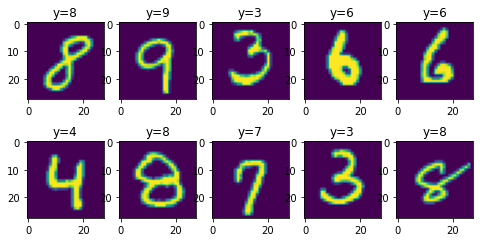

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4), squeeze=False)

for i in range(10):
    r = i // 5
    c = i % 5
    idx = np.random.choice(len(train_data), 1)[0]
    x = train_data[idx][0].numpy()
    y = train_data[idx][1]
    axes[r, c].imshow(x[0, :, :])
    axes[r, c].set_title('y={}'.format(y))

plt.show()

# Let's train a neural net !

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

seed = 42

# Hyperparameters
lr = 0.01
epochs = 20
epoch_size = 200
train_batch_size = 64
test_batch_size = 256

# detect if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

# set up the data loaders
train_sampler = torch.utils.data.RandomSampler(train_data, replacement=True, num_samples=epoch_size*train_batch_size)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)


# Model definition
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, X):
        X = X.view(-1, 28*28)  # flatten images
        X = self.fc1(X)
        return F.log_softmax(X, dim=-1)


torch.manual_seed(seed)

model = NeuralNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

def train():

    mean_loss = 0.
    n_processed = 0

    model.train()
    for X, Y in train_loader:

        X = X.to(device)
        Y = Y.to(device)

        # Forward pass
        Y_logprob = model(X)

        # Compute expected loss
        loss = F.nll_loss(Y_logprob, Y, reduction='mean')

        # Backward pass
        loss.backward()

        # Parameter update (gradient descent)
        optimizer.step()
        optimizer.zero_grad()

        mean_loss += loss.item() * X.shape[0]
        n_processed += X.shape[0]

    mean_loss /= n_processed
    return mean_loss

def test():
    test_loss = 0
    test_error = 0
    n_processed = 0
    
    model.eval()
    for X, Y in test_loader:

        X = X.to(device)
        Y = Y.to(device)

        with torch.no_grad():
            # Forward pass
            Y_logprob = model(X)

            # Compute the expected negative log-likelihood
            test_loss += F.nll_loss(Y_logprob, Y, reduction='sum').item()

            # Get the mode of p(y|x) (most probable digit)
            Y_pred = Y_logprob.argmax(dim=1)

            # Compute the expected 0/1 error
            test_error += (Y_pred != Y).sum().item()

        n_processed += X.shape[0]

    test_loss /= n_processed
    test_error /= n_processed

    return test_loss, test_error


train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    
    print(f"Epoch {epoch}...")
    
    train_loss = train()
    print(f"Train negative log-likelihood: {train_loss:.6f}")
    
    test_loss, test_error = test()
    print(f"Test  negative log-likelihood: {test_loss:.6f} 0/1 error: {test_error:.6f}")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

In [ ]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(range(epochs), train_losses, label="train")
ax.plot(range(epochs), test_losses, label="test")
ax.set_title("Train / test loss")
ax.legend()
ax.set_xlabel("epochs")
ax.set_ylabel("NLL")
plt.show()

Let's visualize some predictions.

In [ ]:
nrows = 5
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12), squeeze=False)

np.random.seed(0)
idxs = np.random.choice(len(train_data), nrows*ncols)

for i, idx in enumerate(idxs):
    r = i // 5
    c = i % 5
    x = train_data[idx][0].numpy()
    y = train_data[idx][1]
    y_pred = model(torch.tensor(x).to(device)).argmax(dim=-1).item()
    axes[r, c].imshow(x[0, :, :])
    axes[r, c].set_title(f'y={y} pred={y_pred}')

plt.show()

Try playing with the learning rate, batch size, and number of epochs. What is the best accuracy that you can get ?

Try different neural network architectures, and note the results.
*   Multi-layer perceptron (more layers)
*   Convolutional neural net ([convolution layers](https://pytorch.org/docs/stable/nn.html#convolution-layers) + [max pooling](https://pytorch.org/docs/stable/nn.html?highlight=layers#pooling-layers))
*   Residual connections

Objective: get below 1% error: http://yann.lecun.com/exdb/mnist/index.html

Hints:
  - change the gradient descent optimizer to [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)
  - implement an early stopping strategy: $n$ epochs without improvement -> stop
  - set up a learning rate decay strategy ([ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau))